In [372]:
%matplotlib inline
import os
import glob
import pybedtools

import pandas as pd
from matplotlib_venn import venn2, venn3 

from clipper.src import CLIP_analysis
from clipper.src import get_genomic_regions
import flotilla
from gscripts import GO
from gscripts.general import dataviz
from gscripts.general import parsers
from gscripts.general import region_helpers
from gscripts.rnaseq.helpers import counts_to_rpkm

#Generate Stringtie Script to run everything I've got so far

In [373]:
gene_id_to_name = region_helpers.gene_id_to_name("/projects/ps-yeolab/genomes/hg19/gencode.v17.annotation.gtf.db")
gene_id_to_type = region_helpers.gene_id_to_type("/projects/ps-yeolab/genomes/hg19/gencode.v17.annotation.gtf.db")


In [374]:
def stringtie(fn):
    return "stringtie {} -G /projects/ps-yeolab/genomes/hg19/gencode/v19/gencode.v19.annotation.gtf -f .01 -g 25 -p 16 -A {} > {}".format(fn, os.path.basename(fn) + ".abundance", os.path.basename(fn) + ".stringtie")

def class_rna(fn, threshold=.05):
    out_file = "{}.cutoff_{}.gtf".format(os.path.basename(fn), threshold)
    return "perl /home/yeo-lab/software/CLASS_2.1.3/run_class.pl -a {} -o {} -F {} -p 16".format(fn,out_file, threshold) 

In [375]:
def eplouge(count):
    return """#!/bin/bash
#PBS -N class_rna
#PBS -l nodes=1:ppn=16
#PBS -o stringtie.out
#PBS -e stringtie.err
#PBS -V
#PBS -q condo
#PBS -t 1-{}
#PBS -l walltime=8:00:00
cd /home/gpratt/projects/cryptic_exons/analysis/ad-hoc/class/
echo "hello, starting"
""".format(count)

prolouge = "eval ${cmd[$PBS_ARRAYID]}"

In [376]:
files_to_submit = glob.glob("/home/gpratt/projects/cryptic_exons/analysis/ad-hoc/stringite/*.bam")

In [377]:
result = []
for total, x in enumerate(files_to_submit):
    total += 1
    result.append('cmd[{}]=\"{}\"'.format(total, stringtie(x)))
    
with open(os.path.join("/home/gpratt/projects/cryptic_exons/scripts", "stringtie.sh"), 'w') as out_file:
    out_file.write(eplouge(total))
    for line in result:
        out_file.write(line + "\n\n")
    out_file.write(prolouge + "\n")

In [381]:
result = []
total = 0
for x in files_to_submit:
    total += 1
    result.append('cmd[{}]=\"{}\"'.format(total, class_rna(x, ".001")))
    total += 1
    result.append('cmd[{}]=\"{}\"'.format(total, class_rna(x, ".01")))
    total += 1
    result.append('cmd[{}]=\"{}\"'.format(total, class_rna(x, ".05")))
    total += 1
    result.append('cmd[{}]=\"{}\"'.format(total, class_rna(x, ".1")))

    
with open(os.path.join("/home/gpratt/projects/cryptic_exons/scripts", "class_rna.sh"), 'w') as out_file:
    out_file.write(eplouge(total))
    for line in result:
        out_file.write(line + "\n\n")
    out_file.write(prolouge + "\n")

#Analyze Data 
(I've done this a bit before, just want to double check, don't know why it was so wrong before)

In [ ]:
def correct_gtf_start(interval):
    interval.start += 1
    return interval

def filter_by_abundance(interval):
    gtf_info = dict(item.split() for item in interval[8].split(";"))
    abundance = float(gtf_info['Abundance'][1:-1])
    return abundance > 2

In [233]:
def find_cryptic_exons(kd, ctrl):
    annotated_exons = pybedtools.BedTool("/home/gpratt/clipper/clipper/data/regions/hg19_exons.bed").sort().saveas()
    annotated_genes = pybedtools.BedTool("/home/gpratt/clipper/clipper/data/regions/hg19_genes.bed")
    protein_coding_genes = annotated_genes.filter(lambda x: gene_id_to_type[x.name] == "protein_coding" ).saveas()

    kd_exons = pybedtools.BedTool(kd)
    kd_exons = kd_exons.filter(lambda x: x[2] == "exon").sort().sort().saveas()
    kd_exons = kd_exons.each(correct_gtf_start).saveas()

    ctrl_exons = pybedtools.BedTool(ctrl)
    ctrl_exons = ctrl_exons.filter(lambda x: x[2] == "exon").sort().saveas()
    gene_exons = kd_exons.intersect(protein_coding_genes, f=1.0, u=True).saveas()
    kd_annotated_exons = gene_exons.intersect(annotated_exons, u=True, f=1.0, r=True, sorted=True).saveas()
    kd_unannotated_exons = gene_exons.intersect(annotated_exons, f=1.0, r=True, sorted=True, v=True).saveas()
    kd_crypic_exons = kd_unannotated_exons.intersect(annotated_exons, v=True).saveas()
    only_kd_crypic_exons = kd_crypic_exons.intersect(ctrl_exons, v=True, s=True).saveas()
    highly_expressed_exons = only_kd_crypic_exons.filter(filter_by_abundance).saveas()
    return highly_expressed_exons

In [168]:
len(kd_exons), len(gene_exons), #len(ctrl_exons)

(406941, 371160)

In [170]:
len(kd_annotated_exons), #len(ctrl_annotated_exons)

(206487,)

In [188]:
len(kd_unannotated_exons), len(kd_crypic_exons), len(only_kd_crypic_exons)

(164673, 11520, 8013)

In [214]:
len(highly_expressed_exons)

726

In [234]:
SRR2002766_1_cryptic = find_cryptic_exons("/home/gpratt/projects/cryptic_exons/analysis/ad-hoc/class/SRR2002765_1.polyATrim.adapterTrim.rmRep.sorted.rg.bam.gtf",
                   "/home/gpratt/projects/cryptic_exons/analysis/ad-hoc/class/SRR2002766_1.polyATrim.adapterTrim.rmRep.sorted.rg.bam.gtf")

In [324]:
stress_df = pd.DataFrame(pd.Series({os.path.basename(fn).split(".")[0]: fn for fn in files_to_submit}, name="bam_file"))
stress_df = stress_df.join(pd.read_excel("/home/gpratt/Dropbox/cryptic_splicing/data/human_data/data_annotations.xlsx", "Sheet1"))
stress_df['class_gtf'] = stress_df.bam_file.apply(lambda x: x.replace("stringite", "class") + ".gtf")
stress_df = stress_df[stress_df.cell_type != "Mouse_ES"].copy()

In [331]:
for cell_type, cell_type_df in stress_df.groupby("cell_type"):
    for rep, df in cell_type_df.groupby("rep"):
        print cell_type, rep

        wt = df[df.stress == "WT"].class_gtf[0]
        for condition in df[df.stress != "WT"].class_gtf:
            find_cryptic_exons(condition, wt).saveas(os.path.basename(condition).split(".")[0] + ".bed")

ALS17 rep1
AV47d rep1
CVB rep1
GY6 rep1
HeLa rep1
HepG2 rep1
HepG2 rep2
HepG2 rep3
K562 rep1
K562 rep2
K562 rep3
KIn1ALS17 rep1
MN rep1


In [335]:
bed_files = glob.glob("*.bed")

In [351]:
cryptic_exons = pd.DataFrame(pd.Series({fn.split(".")[0]: fn for fn in bed_files}, name="bed_files"))
cryptic_exons = cryptic_exons.join(pd.read_excel("/home/gpratt/Dropbox/cryptic_splicing/data/human_data/data_annotations.xlsx", "Sheet1")).dropna()

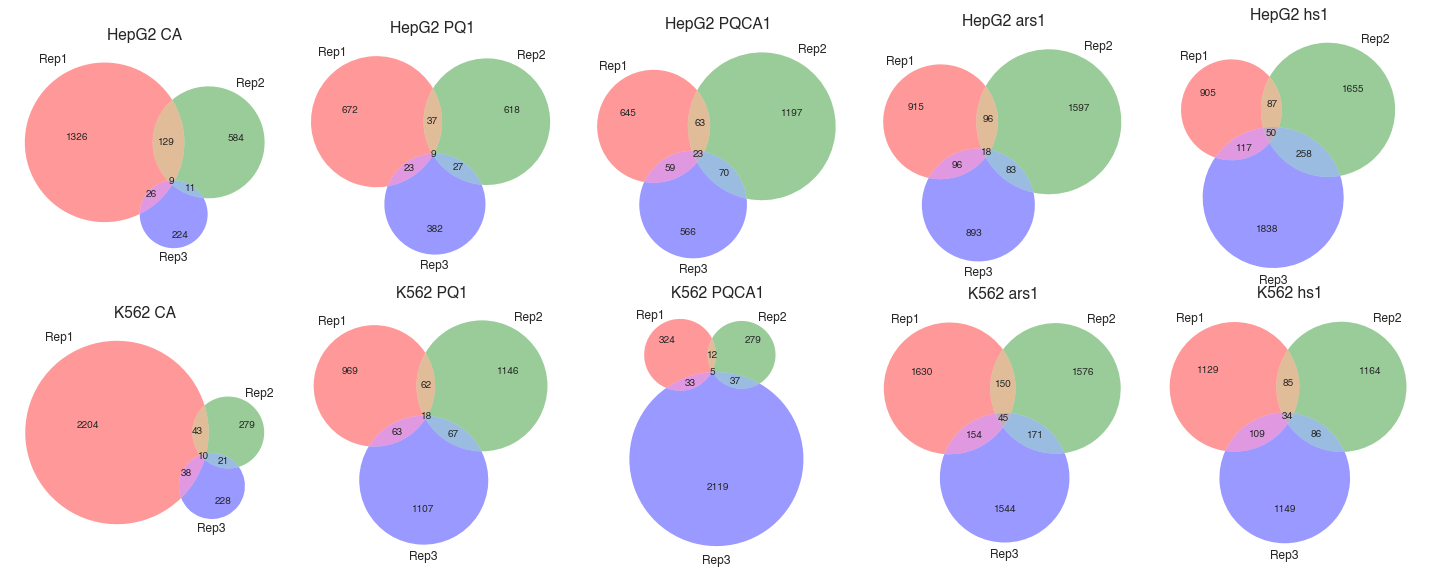

In [368]:
count = 0
num_cols = 5
num_rows = 2
with dataviz.Figure(os.path.join(img_dir, "overlapping_sites.svg"), figsize=(4 * num_cols,4*num_rows)) as fig:
    for name, df in cryptic_exons.groupby(["cell_type", "stress"]):
        if len(df.bed_files) == 3:
            count += 1
            rep1, rep2, rep3 = df.bed_files
            rep1 = pybedtools.BedTool(rep1)
            rep2 = pybedtools.BedTool(rep2)
            rep3 = pybedtools.BedTool(rep3)

            ax = fig.add_subplot(num_rows, num_cols, count)

            venn3({"001": len(rep1.intersect(rep2, s=True, v=True).intersect(rep3, s=True, v=True)),
                   "010": len(rep2.intersect(rep3, s=True, v=True).intersect(rep1, s=True, v=True)),
                   "011": len(rep2.intersect(rep1, s=True, u=True).intersect(rep3, s=True, v=True)),
                   "100": len(rep3.intersect(rep2, s=True, v=True).intersect(rep1, s=True, v=True)),
                   "101": len(rep3.intersect(rep2, s=True, v=True).intersect(rep1, s=True, u=True)),
                   "110": len(rep3.intersect(rep2, s=True, u=True).intersect(rep1, s=True, v=True)),
                   "111": len(rep3.intersect(rep2, s=True, u=True).intersect(rep1, s=True, u=True)),
                  },
                  set_labels=["Rep1", "Rep2", "Rep3"], ax=ax)
            rep3.intersect(rep2, s=True, u=True).intersect(rep1, s=True, u=True).saveas("consistant_" + "_".join(name) + ".bed")
            ax.set_title(" ".join(name))

#What about merging and quantifying?

Code to merge all the hepg2 and k562 events on the commandline

samtools merge HepG2_merged.bam HepG2*.bam

samtools merge K562_merged.bam K562*.bam

cat HepG2_merged.bam.cutoff_.01.gtf | awk '{if($7 != ".") print $0}' > HepG2_merged.bam.cutoff_.01.only_stranded.gtf 

python /projects/ps-yeolab/software/bin/dexseq_prepare_annotation.py HepG2_merged.bam.cutoff_.01.only_stranded.gtf HepG2_merged.bam.cutoff_.01.only_stranded.flat.gtf